< 출처 : 박조은 강사님 [Github](https://github.com/corazzon/KaggleStruggle/blob/master/kaggle-survey-2017/Kaggle-ML-DS-survey-2017-EDA-FAQ.ipynb) >

#Load Dataset

In [93]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [94]:
#구글 드라이브 연동하기
#구글 드라이브에 데이터를 올린 후 사용할 경우에만 실행
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/충북대 AI특강/실습 파일/[2일차]1.kaggle 실습/kaggle_bike/data/bike/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [96]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/충북대 AI특강/실습 파일/[2일차]1.kaggle 실습/kaggle_bike/data/bike/test.csv", parse_dates=["datetime"])
test.shape
#test.head()

(6493, 9)

In [97]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [98]:
train.temp.describe() #기온 데이터 확인

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [99]:
train.isnull().sum()  # null 데이터 시각화 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

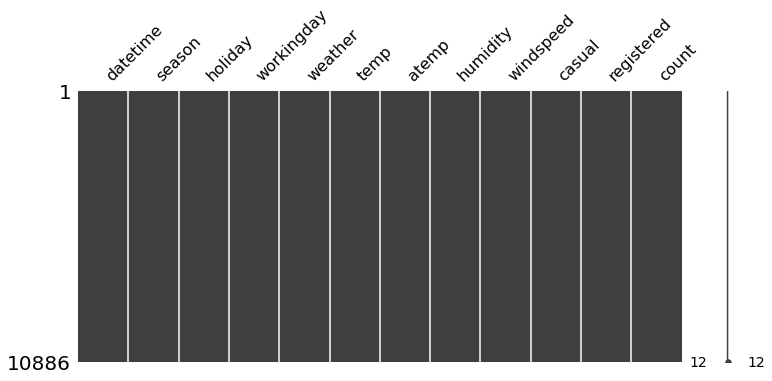

In [100]:
# null 데이터 시각화 확인
import missingno as msno
msno.matrix(train,figsize=(12,5))

#Feature Engineering

In [101]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [102]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape
#test.head()

(6493, 16)

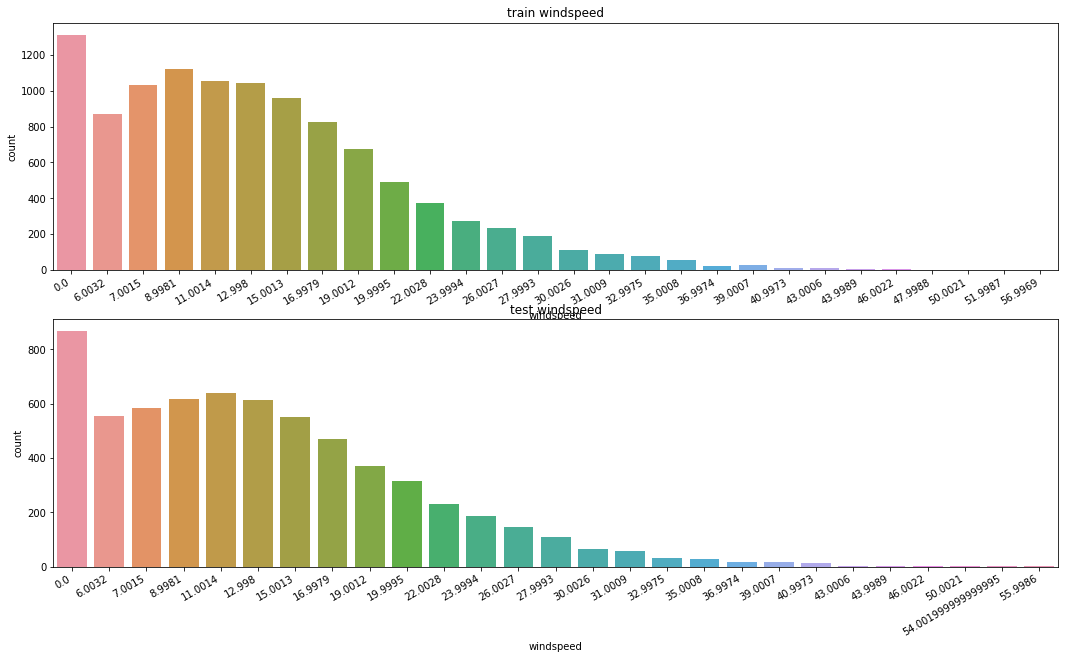

In [103]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [104]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [105]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)


(1313, 19)
(9573, 19)


In [106]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

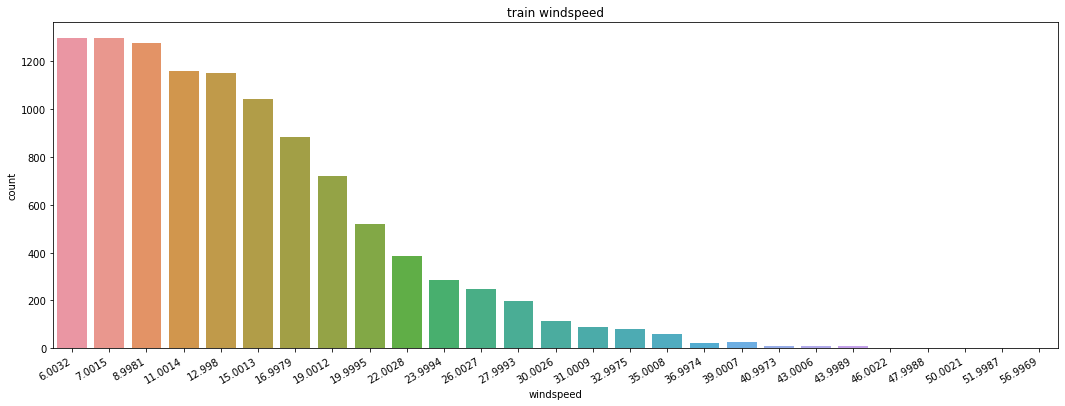

In [107]:
# 가비지인 0값을 없앤다.
train = predict_windspeed(train)
#test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

#Feature Selection

* 신호와 소음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [108]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"], 높낮이가 있음 
# 범주형 feature의 type을 category로 변경 해 준다. 
# category가 우리말로 범주형이다. 이부분에 헷갈리지 않도록
# 범주형 데이터를 범주형 타입의 변수로 변경한다는 의미
# 예를 들어 계절은 봄=0,여름=1,가을=3,겨울=4 이렇게 범주형 데이터이기 때문에 변수 타입을 category로 변경한다는 의미

categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [109]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [110]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [111]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [112]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

#Score

##RMSLE

과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

 
 
$ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( p_i + 1) - \log(a_i + 1))^2} } $
$ = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log \frac {p_i + 1} {a_i + 1} )^2} } $
 

 
n  is the number of hours in the test set

p_i  is your predicted count

a_i  is the actual count

log(x) is the natural logarithm

좀 더 자세한 설명은 : [RMSLE cost function](https://www.slideshare.net/KhorSoonHin/rmsle-cost-function)


잔차(residual)에 대한 평균에 로그를 씌운 값이다. 
=> 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.

값이 작을 수록 오류가 적다는 의미를 나타낸다.

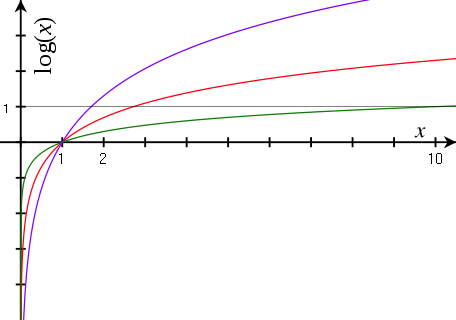

image.png이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그

In [113]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 1을 더하는 이유는 0일때 마이너스 무한대가 되기 때문에 1을 더해주고 로그를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

##Cross Validation 교차 검증

* 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.
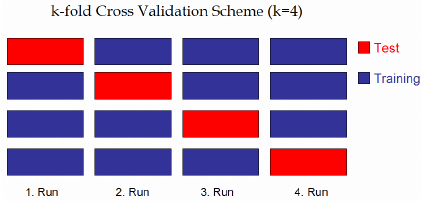

이미지 출처 : https://www.researchgate.net/figure/228403467_fig2_Figure-4-k-fold-cross-validation-scheme-example


* KFold 교차검증
  * 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
  * 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
  * 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
  * 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
  * 이 과정을 마지막 폴드까지 반복한다.
  * 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [114]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#RandomForest

In [115]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [116]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

# 이 스코어는 캐글에 서브미션을 올리면 자동으로 계산해주시만, 
# 교육상 스코어를 미리 확인해 본다는 취지에서 계산하는 것임.


CPU times: user 3.67 s, sys: 833 ms, total: 4.51 s
Wall time: 31 s
Score= 0.33090


##Train

In [118]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [119]:
# Train Data로 학습을 하고 Test Data로 예측 해본다.
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.49,   5.04,   4.2 ,   3.42,   3.16,   6.2 ,  37.93, 106.08,
       235.94, 136.41])

[Text(0.5, 1.0, 'test')]

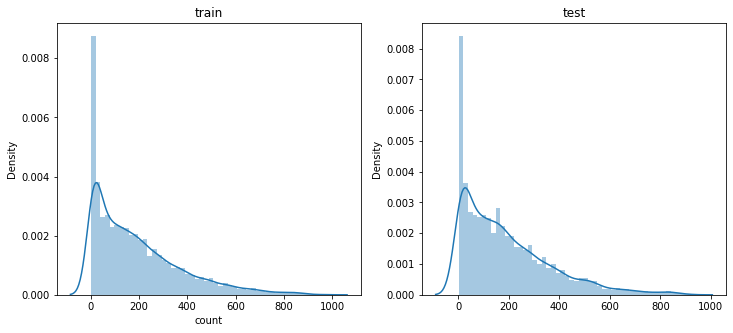

In [120]:
# Test Data로 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train") # 학습한 모델의 가시화
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")  # 테스트 결과의 가시화

##Submit

In [123]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/충북대 AI특강/실습 파일/[2일차]1.kaggle 실습/kaggle_bike/data/bike/sampleSubmission.csv")
submission
print(submission.shape)
submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)
(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.49
1,2011-01-20 01:00:00,5.04
2,2011-01-20 02:00:00,4.20
3,2011-01-20 03:00:00,3.42
4,2011-01-20 04:00:00,3.16


In [122]:
submission.to_csv("/content/drive/My Drive/Colab Notebooks/충북대 AI특강/실습 파일/[2일차]1.kaggle 실습/kaggle_bike/data/bike/Score_{0:.5f}_submission.csv".format(score), index=False)

참고 :

*  [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
*  [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -1)](https://colab.research.google.com/drive/1aD1AWEshSX3VuCMvH2_emUuv7EKcc9eu#scrollTo=p1NASWPQe7rr&line=3&uniqifier=1)
*  [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -2)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d)

In [91]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/충북대 AI특강/실습 파일/[2일차]1.kaggle 실습/kaggle_bike/data/bike/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

!ls -al 

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.60
1,2011-01-20 01:00:00,3.59
2,2011-01-20 02:00:00,3.21
3,2011-01-20 03:00:00,6.14
4,2011-01-20 04:00:00,38.22
